In [1]:
# Just taking the 2 --> 1 transition
# Or up_level = 2; low_level = 1
# i.e., i = 1; j = 0

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as cm
import pynbody
from michaels_functions import center_and_r_vir, remove_bulk_velocity
from matplotlib.colors import LogNorm
from matplotlib.pyplot import figure

In [3]:
n_H_arr = pynbody.array.SimArray(np.load('outputs/sub_grid/n_H.npy'), "cm**-3")
n_H2_arr = pynbody.array.SimArray(np.load('outputs/sub_grid/n_H2.npy'), "cm**-3")
X_H2_arr = pynbody.array.SimArray(np.load('outputs/sub_grid/X_H2.npy'), "1")
n_LW_arr = np.load('outputs/sub_grid/n_LW.npy')
n_LW_ss_arr = np.load('outputs/sub_grid/n_LW_ss.npy')
X_H2_ss_arr = pynbody.array.SimArray(np.load('outputs/sub_grid/X_H2_ss.npy'), "1")
n_H2_ss_arr = pynbody.array.SimArray(np.load('outputs/sub_grid/n_H2_ss.npy'), "cm**-3")
X_CO_arr = pynbody.array.SimArray(np.load('outputs/sub_grid/X_CO.npy'), "1")
n_CO_arr = pynbody.array.SimArray(np.load('outputs/sub_grid/n_CO.npy'), "cm**-3")
pdf_arr = np.load('outputs/sub_grid/pdf.npy')
lambda_jeans_arr = pynbody.array.SimArray(np.load('outputs/sub_grid/lambda_jeans.npy'), "cm")

In [4]:
#Defining all the constants used in this whole program

m_p = pynbody.array.SimArray(1.672621777e-24, "g")
K_b = pynbody.array.SimArray(1.38064852e-16, "cm**2 g s**-2 K**-1")
K_b_ev = pynbody.array.SimArray(8.617e-5, "eV K**-1")
G = pynbody.array.SimArray(6.67259e-8, "cm**3 g**-1 s**-2")
T_mean = pynbody.array.SimArray(10., "K")
mach_no = pynbody.array.SimArray(10., "1")
metallicity = 0.02/0.02
G_o = 1
n_H_mean = pynbody.array.SimArray(100., "cm**-3")
# c_si = pynbody.array.SimArray(299792458, "m s**-1")
c_cgs = pynbody.array.SimArray(2.99792458e10, "cm s**-1")
h_ev = pynbody.array.SimArray(4.13566770e-15, "eV s")
# h_si = pynbody.array.SimArray(6.626e-34, "J s")
mH_cgs = pynbody.array.SimArray(1.6737236e-24, 'g')  # hydrogen mass
T_bg = pynbody.array.SimArray(2.73, "K")
eV = pynbody.array.SimArray(6.241509e18, "J")

#pynbody.array.SimArray(, "")

In [5]:
def get_filename(species):
    # filename is already given
    if (species[-4:] == '.dat') or (species[-4:] == '.txt'):
        return species
    # molecule is chosen
    THIS_FOLDER = os.path.dirname(os.path.abspath(__file__))
    database = os.path.join(THIS_FOLDER, 'LAMDA')
    if species == 'HCO+':
        filename = os.path.join(database, 'HCO+.dat')
    elif species == 'H13CO+':
        filename = os.path.join(database, 'H13CO+.dat')
    elif species == 'N2H+':
        filename = os.path.join(database, 'N2H+.dat')
    elif species == 'SiO':
        filename = os.path.join(database, 'SiO.dat')
    elif species == 'HNC':
        filename = os.path.join(database, 'HNC.dat')
    elif species == 'HCN':
        filename = os.path.join(database, 'HCN.dat')
    elif species == 'CO':
        filename = os.path.join(database, 'CO.dat')
    else:
        print('Unknow species. Chose from HCO+, H13CO+, N2H+, SiO, HNC, HCN, CO')
        print('or provide a LAMDA datafile.')
        exit()

    return filename

def read_file(species):
    filename = get_filename(species)
    f = open(filename, 'r')

    f.readline()
    species = f.readline()

    f.readline()
    mu = float(f.readline())  # molecular weight

    f.readline()
    num_lvls = int(f.readline())  # number of energy levels

    # read energy levels: energy E, statistical weight g
    f.readline()
    E = []
    g = []
    for l in range(num_lvls):
        words = f.readline().split()
        E.append(float(words[1]) *c_cgs*h_ev) # cm^-1 -> eV
        g.append(float(words[2]))

    f.readline()
    num_trans = int(f.readline())  # number of radiative transistions

    # read transistions: upper lvl, lower lvl, A-coefficient, frequency
    f.readline()
    A = np.zeros((num_lvls, num_lvls))
    freq = np.zeros((num_lvls, num_lvls))
    for t in range(num_trans):
        words = f.readline().split()
        up = int(words[1]) - 1
        low = int(words[2]) - 1
        if up-low==1:
            A[up][low] = float(words[3])  # s^-1
            freq[up][low] = float(words[4]) * 1e9  # GHz -> Hz
            #freq[low][up] = freq[up][low] #un-comment this only if low->up transitions are also allowed

    # compute B-coefficient via Einstein relations
    # Bij = coeff for stimulated emission, Bji = coeff for extinction (j<i)
    B = np.zeros((num_lvls, num_lvls))
    for i in range(0, num_lvls):
        for j in range(0, i):
            if A[i][j] != 0:
                B[i][j] = A[i][j] * (c_cgs**2) / (2*h_ev * (freq[i][j])**3) # cm2/(eV*s)
                B[j][i] = B[i][j] * g[i]/g[j]

    # number of collision partners in the data file
    f.readline()
    num_partners = int(f.readline())

    C_all = []
    temps_all = []
    for partner in range(num_partners):
        # reference
        f.readline()
        line = f.readline()

        # number of collisional transitions
        f.readline()
        num_coll = int(f.readline())

        # number of temperatures in the table
        f.readline()
        num_temps = int(f.readline())

        # read the temperature values
        f.readline()
        words = f.readline().split()
        temps = np.zeros(num_temps)
        for t in range(num_temps):
            temps[t] = float(words[t])
            temps_all.append(temps)  # K

        # read collision coeff data: upper lvl, lower lvl, C-coefficient for each temp
        C = np.zeros((num_temps, num_lvls, num_lvls))
        f.readline()
        for col in range(num_coll):
            words = f.readline().split()
            i = int(words[1]) - 1
            j = int(words[2]) - 1
            for t in range(num_temps):
                C[t][i][j] = float(words[3+t]) #* 1.e-6 # cm3/s -> m3/s

        # calculate the inverse coefficient via LTE relation
        for i in range(num_lvls):
            for j in range(i):
                for t in range(num_temps):
                    if C[t][i][j] != 0:
                        C[t][j][i] = C[t][i][j] * np.exp(-(E[i]-E[j])/(K_b_ev*temps[t]))*g[i]/g[j]

        # add collision partner data to global array
        C_all.append(C)

    f.close()
    C_all = np.array(C_all) #cm3/s
    temps_all = np.array(temps_all) #K
    E = np.array(E) #eV
    g = np.array(g) 
    freq = np.array(freq) #Hz
    A = np.array(A) #s-1
    B = np.array(B) #cm2/(eV*s)
    return mu, num_lvls, E, g, freq, A, B, C_all, num_partners, temps_all, num_temps, num_coll

''' Load preset abundances and fraction for collision coefficients
    PARAMS:
      species = string with the particle name
    RETURNS:
      comp_fracs = list with the fraction of total collision partner density for each partner
      abundance = overall abundance of the molecule (assume n_mol = abundance*rho everywhere)'''
def load_species_info(species):

    if species == 'HCO+':
        comp_fracs = [1.0] # only 1 collision partner in HCO data
        abundance = 1.e-09 # = N_species/N_h2
    elif species == 'H13CO+':
        comp_fracs = [1.0] # only 1 collision partner in HCO data
        abundance = 2.e-11
    elif species == 'N2H+':
        comp_fracs = [1.0] # only 1 collision partner in HCO data
        abundance = 1.e-10
    elif species == 'SiO': # is seems to be unusually slow
        comp_fracs = [1.0] # only 1 collision partner in HCO data
        abundance = 7.7e-12
    elif species == 'HNC':
        comp_fracs = [1.0] # only 1 collision partner in HCO data
        abundance = 3.1e-10
    elif species == 'HCN':
        comp_fracs = [1.0, 0.0] # H2 and e
        abundance = 3.1e-11
    elif species == 'CO':
        comp_fracs = [0.66, 0.33] # para H2 and orhto H2
        #abundance = 1.e-4
        abundance = 1.0 # dummy for filenames
    else:
        print 'ERROR: Unsupported species'
        exit()

    return comp_fracs, abundance

''' Calculate net collision coeff for a gas consisting of different components at temp T
    Interpolates table betweem T values
    PARAMS:
      T = temperature (K)
      comp_fractions = fraction of the total density in each component
    RETRUN:
      C = netto collision coeff C[i][j] (m3/s) '''
def calc_total_C(T, comp_fractions):
    C = np.zeros((num_lvls,num_lvls))
    for p in range(num_partners):
        max_index = len(temps_all[p])
        if T <= temps_all[p][0]: # T is lower than lowest value in table
            for i in range(num_lvls):
                for j in range(num_lvls):
                    C[i][j] = C[i][j] + comp_fractions[p] * C_all[p][0][i][j]
        elif T >= temps_all[p][max_index-1]: # T is higher than highest value in table
            for i in range(num_lvls):
                for j in range(num_lvls):
                    C[i][j] = C[i][j] + comp_fractions[p] * C_all[p][max_index-1][i][j]
        else: # determine temperature entries needed to interpolate
            t = 1 # T index of upper limit
            while temps_all[p][t] < T:
                t = t+1
            t_frac = (temps_all[p][t] - T)/(temps_all[p][t] - temps_all[p][t-1])
            for i in range(num_lvls):
                for j in range(num_lvls):
                    interpol = (1-t_frac) * C_all[p][t][i][j] + t_frac * C_all[p][t-1][i][j]
                    C[i][j] = C[i][j] + comp_fractions[p] * interpol

    return C

In [6]:
mu, num_lvls, E, g, freq, A, B, C_all, num_partners, temps_all, num_temps, n_coll = read_file('CO.txt')

In [7]:
comp_fractions, abundance = load_species_info('CO')

In [8]:
# calc netto collision coeffs
C = calc_total_C(T_mean, comp_fractions)

In [9]:
def partion_function(T, num_lvls, g, E):
    Z=0.0
    for i in range(0,num_lvls):
        Z = Z + g[i]*np.exp(-E[i]/(K_b_ev*T))
    return np.array(Z)

def calc_lvlpops_partion(T, num_lvls, g, E):
    ni = np.zeros(num_lvls)
    Z = partion_function(T, num_lvls, g, E)
    for i in range(0, num_lvls):
        ni[i] = g[i]*np.exp(-E[i]/(K_b_ev*T)) / Z
    return np.array(ni), Z

In [10]:
ni, Z = calc_lvlpops_partion(T_mean, num_lvls, g, E)
ni = pynbody.array.SimArray(ni, "1")

In [11]:
c_s = np.sqrt(K_b * T_mean/(mH_cgs*mu))
c_s

SimArray(5427.76055106, 'cm s**-1')

In [12]:
def tau_LVG(N, nu_ij, lambda_jeans, n_i, n_j, B_ij, B_ji, c_s):
    # units: eV*s * 1/s * cm * 1/cm3 * cm2/(eV*s) * 1/(1/s) = none
    delta_nu = c_s*nu_ij/c_cgs #units: 1/s
    return h_ev*nu_ij*lambda_jeans*N*((n_j*B_ji)-(n_i*B_ij)) / (4*np.pi*delta_nu)

def beta_LVG(tau):
    if tau < 0.01:
        return 1. - tau/2.
    elif tau > 100.:
        return 1./tau
    else:
        return (1.0 - np.exp(-tau)) / tau

def B_nu_ev(nu, T):
    if nu==0.:
        return 0.
    if nu>1:
        x = h_ev*nu/(K_b_ev*T) #units: none
        #units: eV*s * Hz3 / (cm2/s2) = eV * s3 * Hz3 * cm-2 = eV/s/Hz/cm2 = eV/cm2
        B_nu_ev = 2.0*h_ev*(nu**3) / ((c_cgs**2) * (np.exp(x)-1.0))
        return B_nu_ev

def LTE_solver(I_nu_bg, B_nu, beta):
    return (((1-beta)*B_nu) + beta*I_nu_bg)


In [13]:
tau_nu = np.zeros((len(n_CO_arr)))
beta_nu = np.zeros((len(n_CO_arr)))
B_nu = np.zeros((len(n_CO_arr)))
I_nu_bg = np.zeros((len(n_CO_arr)))
I_nu = np.zeros((len(n_CO_arr)))
for ctr in range(0, 100):
    n_H = n_H_arr[ctr]
    n_CO = n_CO_arr[ctr]
    lambda_jeans = lambda_jeans_arr[ctr]
    N = n_CO
    Ni = pynbody.array.SimArray(ni*N, "cm**-3")
    u = 1 #upper level
    l = 0 #lower level
    nu = freq[u][l]
    n_i = ni[u]
    n_j = ni[l]
    A_ij = A[u][l]
    B_ij = B[u][l]
    B_ji = B[l][u]
    tau_nu[ctr] = tau_LVG(N, nu, lambda_jeans, n_i, n_j, B_ij, B_ji, c_s)
    beta_nu[ctr] = beta_LVG(tau_nu[ctr])
    B_nu[ctr] = B_nu_ev(nu, T_mean)
    I_nu_bg[ctr] = B_nu_ev(nu, T_bg)
    I_nu[ctr] = LTE_solver(I_nu_bg[ctr], B_nu[ctr], beta_nu[ctr])

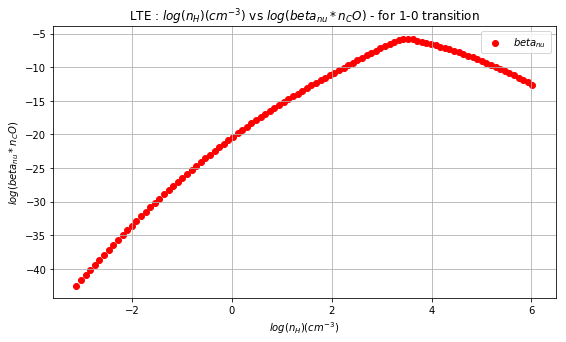

In [14]:
plt.figure(figsize=(9,5))
plt.scatter(np.log10(n_H_arr), np.log10(beta_nu*n_CO_arr*pdf_arr), c='r',
            label='$beta_{nu}$')
# plt.scatter(np.log10(n_H_arr), X_CO_arr)
plt.xlabel('$log(n_{H}) (cm^{-3})$')
plt.ylabel('$log(beta_{nu} * n_CO)$')
plt.grid(b=True, which='both', axis='both')
plt.title('LTE : $log(n_{H}) (cm^{-3})$ vs $log(beta_{nu} * n_CO)$ - for 1-0 transition')
plt.legend()
plt.savefig('radiative_transfer/outputs_RT/1.1/LTE_log(n_H)vsbeta.png', 
            dpi=300, bbox_inches='tight')
plt.show()

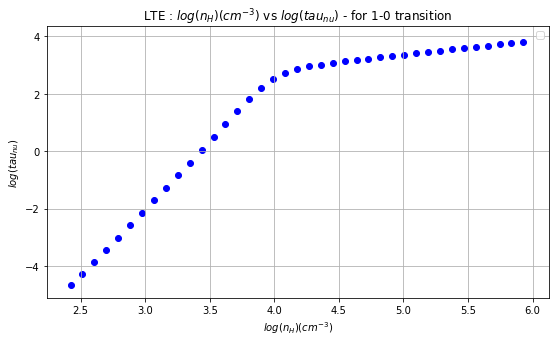

In [15]:
plt.figure(figsize=(9,5))
tau_tau = 1
for k in range(0, 100):
    if (np.log10(tau_nu[k])>-5) & (np.log10(tau_nu[k])<5):
        if (np.log10(n_H_arr[k])>2) & (np.log10(n_H_arr[k])<6):
            plt.scatter(np.log10(n_H_arr[k]), np.log10(tau_nu[k]), c='b')
plt.xlabel('$log(n_{H}) (cm^{-3})$')
plt.ylabel('$log(tau_{nu})$')
plt.grid(b=True, which='both', axis='both')
plt.title('LTE : $log(n_{H}) (cm^{-3})$ vs $log(tau_{nu})$ - for 1-0 transition')
plt.legend()
plt.savefig('radiative_transfer/outputs_RT/1.1/LTE_log(n_H)vslog(tau).png', 
            dpi=300, bbox_inches='tight')
plt.show()

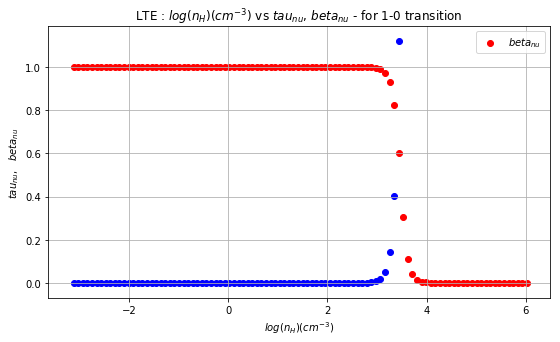

In [16]:
plt.figure(figsize=(9,5))
plt.scatter(np.log10(n_H_arr), beta_nu, c='r',
            label='$beta_{nu}$')
for i in range(0, 100):
    if (tau_nu[i]<2):
        plt.scatter(np.log10(n_H_arr[i]), tau_nu[i], c='b')
# plt.scatter(np.log10(n_CO_arr[71]), tau_nu[71], c='b',
#                 label='$tau_{nu}$')
plt.xlabel('$log(n_{H}) (cm^{-3})$')
plt.ylabel('$tau_{nu}$,   $beta_{nu}$')
plt.grid(b=True, which='both', axis='both')
plt.title('LTE : $log(n_{H}) (cm^{-3})$ vs $tau_{nu}$, $beta_{nu}$ - for 1-0 transition')
plt.legend()
# plt.savefig('radiative_transfer/outputs_RT/1.1/LTE_log(n_CO)_vs_tau_vs_beta.png', 
#             dpi=300, bbox_inches='tight')
plt.show()

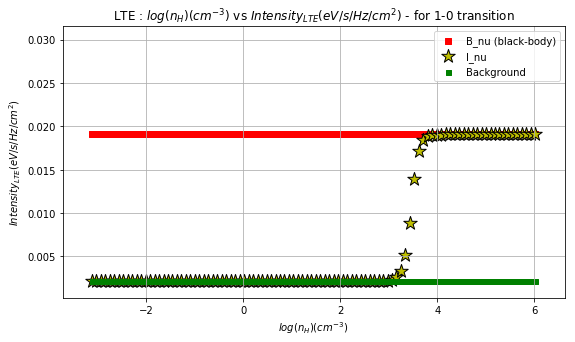

In [17]:
plt.figure(figsize=(9,5))
plt.scatter(np.log10(n_H_arr), B_nu, c='r', marker='s',
            label='B_nu (black-body)')
plt.scatter(np.log10(n_H_arr), I_nu, c='y', marker='*', edgecolors = 'k',
            s=200, label='I_nu')
plt.scatter(np.log10(n_H_arr), I_nu_bg, c='g', marker='s',
            s=25, label='Background')

# plt.scatter(np.log10(n_CO_arr), S_nu, c='b',
#             label='S_nu')
plt.xlabel('$log(n_{H}) (cm^{-3})$')
plt.ylabel('$Intensity_{LTE} (eV/s/Hz/cm^2)$')
plt.grid(b=True, which='both', axis='both')
plt.title('LTE : $log(n_{H}) (cm^{-3})$ vs $Intensity_{LTE} (eV/s/Hz/cm^2)$ - for 1-0 transition')
plt.legend()
plt.savefig('radiative_transfer/outputs_RT/1.1/LTE_log(n_H)vsIntensity.png', 
            dpi=300, bbox_inches='tight')
plt.show()

In [18]:
print "i  n_H                      tau                        beta    I_nu"
for k in range(0,100):
    print k,"",n_CO_arr[k],"   ",tau_nu[k],"   ",beta_nu[k],"   ",I_nu[k]

i  n_H                      tau                        beta    I_nu
0  5.208016862739764e-32     1.3580178434911794e-25     1.0     0.002139806738735271
1  1.2186600714096998e-31     2.8574915879019086e-25     1.0     0.002139806738735271
2  2.8517484359043585e-31     6.012884678455654e-25     1.0     0.002139806738735271
3  6.673602523267372e-31     1.2653226528765783e-24     1.0     0.002139806738735271
4  1.5618245754872415e-30     2.662824123315979e-24     1.0     0.002139806738735271
5  3.6553545863376686e-30     5.60414064876799e-24     1.0     0.002139806738735271
6  8.555688321794962e-30     1.1795157749206414e-23     1.0     0.002139806738735271
7  2.002680822804955e-29     2.482731883538331e-23     1.0     0.002139806738735271
8  4.6881702523835325e-29     5.226256746740676e-23     1.0     0.002139806738735271
9  1.097573887662686e-28     1.1002475661582537e-22     1.0     0.002139806738735271
10  2.5698469209457244e-28     2.3165047156610184e-22     1.0     0.002139806738735